In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# Set random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)  # For CPU
    torch.cuda.manual_seed_all(seed)  # For all GPUs
    np.random.seed(seed)  # For NumPy
    random.seed(seed)  # For Python random
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
seed = 42
set_seed(seed)

# Mean and standard deviation for normalization (CIFAR-10 specific)
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

# Transformations for the training set (includes data augmentation)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.6),   # Horizontal flip with probability 0.5
    transforms.RandomCrop(32, padding=4),     # Random crop with padding of 4 pixels
    transforms.RandomRotation(15),           # Random rotation of ±15 degrees
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Uncomment if needed
    transforms.ToTensor(),                    # Convert image to tensor
    transforms.Normalize(mean, std)          # Normalize with mean and std
])
# Transformations for the validation and test set (no data augmentation)
test_transforms = transforms.Compose([
    transforms.ToTensor(),                    # Convert image to tensor
    transforms.Normalize(mean, std)          # Normalize with mean and std
])
# Load CIFAR-10 training dataset both augmented and not augmented
dataset_augmented = CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
dataset_normal = CIFAR10(root='./data', train=True, download=True, transform=test_transforms)

# Step 3: Suddividere il dataset in Train (80%) e Validation (20%)
train_size = int(0.8 * len(dataset_augmented))  # 80% dei dati
val_size = len(dataset_augmented) - train_size  # 20% dei dati
train_dataset, val_dataset = random_split(dataset_augmented, [train_size, val_size], generator=torch.Generator().manual_seed(seed))
# take validation indices for not augmented dataset
val_dataset = Subset(dataset_normal, val_dataset.indices)
# Load CIFAR-10 dataset for testing
test_dataset = CIFAR10(
    root='./data', train=False, transform=test_transforms, download=True
)
# DataLoader for the training set
train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2
)
# DataLoader for the validation set
val_loader = DataLoader(
    val_dataset, batch_size=128, shuffle=False, num_workers=2
)
# DataLoader for the test set
test_loader = DataLoader(
    test_dataset, batch_size=128, shuffle=False, num_workers=2
)
# Output the dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Val set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Training set size: 40000
Val set size: 10000
Test set size: 10000


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Dropout to be set
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=drop_rate)  # first dropout added
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)  # dropout after Relu
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0])
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
        nn.Dropout(p=drop_rate),  # second dropout before fc
        nn.Linear(512, num_classes)
        )

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_planes, out_channels, stride))
        self.in_planes = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)
def ResNet34(num_classes=10):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

# Dropout=0.35

In [5]:
drop_rate=0.35
resnet18_from_scratch = ResNet18(num_classes=10) 
model = resnet18_from_scratch.to(device) 
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification tasks
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training and validation functions
def train(model, loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to device (GPU/CPU)
        optimizer.zero_grad()  # Zero the gradients from the previous step
        outputs = model(inputs)  # Forward pass through the model
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters

        total_loss += loss.item()  # Accumulate the loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            outputs = model(inputs)  # Forward pass through the model
            loss = criterion(outputs, targets)  # Compute the loss

            total_loss += loss.item()  # Accumulate the loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50  # Set the number of epochs
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Train the model
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    # Validate the model
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    # Record the loss and accuracy for each epoch
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print the results for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "softmax_035.pth")


Epoch 1/50:
Train Loss: 1.6333, Train Acc: 39.85%
Val Loss: 1.2596, Val Acc: 55.42%
Epoch 2/50:
Train Loss: 1.2814, Train Acc: 54.09%
Val Loss: 1.2022, Val Acc: 57.66%
Epoch 3/50:
Train Loss: 1.1293, Train Acc: 59.85%
Val Loss: 1.0211, Val Acc: 64.32%
Epoch 4/50:
Train Loss: 1.0282, Train Acc: 63.82%
Val Loss: 0.9111, Val Acc: 67.40%
Epoch 5/50:
Train Loss: 0.9406, Train Acc: 67.04%
Val Loss: 0.7608, Val Acc: 73.12%
Epoch 6/50:
Train Loss: 0.8741, Train Acc: 69.41%
Val Loss: 0.8292, Val Acc: 72.12%
Epoch 7/50:
Train Loss: 0.8258, Train Acc: 71.25%
Val Loss: 0.8431, Val Acc: 70.99%
Epoch 8/50:
Train Loss: 0.7818, Train Acc: 72.78%
Val Loss: 0.7463, Val Acc: 74.70%
Epoch 9/50:
Train Loss: 0.7468, Train Acc: 73.95%
Val Loss: 0.6225, Val Acc: 77.96%
Epoch 10/50:
Train Loss: 0.7157, Train Acc: 75.26%
Val Loss: 0.5937, Val Acc: 79.29%
Epoch 11/50:
Train Loss: 0.6894, Train Acc: 76.05%
Val Loss: 0.6045, Val Acc: 79.34%
Epoch 12/50:
Train Loss: 0.6612, Train Acc: 76.96%
Val Loss: 0.5490, Val A

In [6]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


Test Loss: 0.3950, Test Accuracy: 87.77%


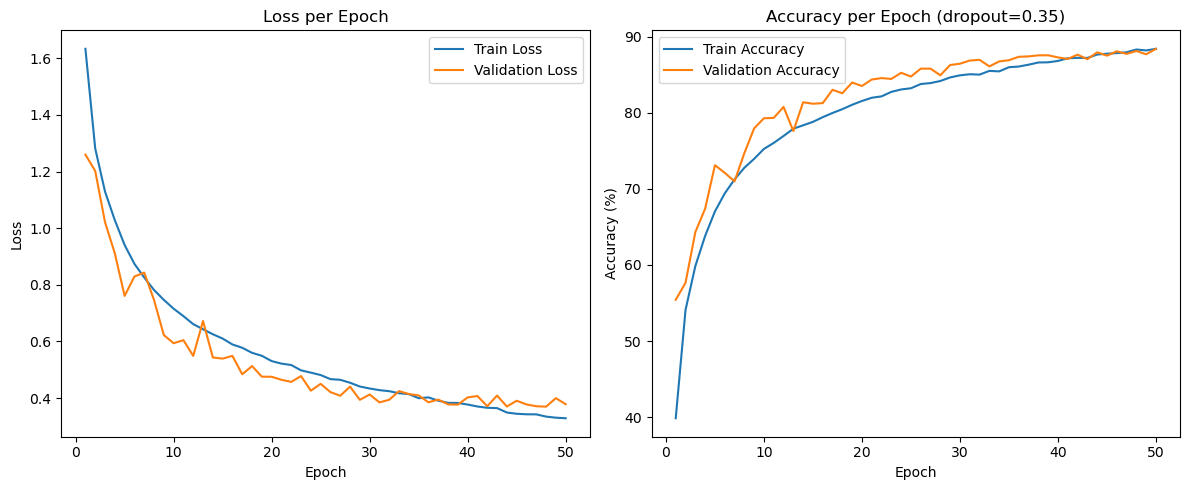

In [7]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (dropout=0.35)")
plt.legend()

plt.tight_layout()
plt.show()

# Dropout=0.4

In [8]:
drop_rate=0.4
resnet18_from_scratch = ResNet18(num_classes=10) 
model = resnet18_from_scratch.to(device) 
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification tasks
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training and validation functions
def train(model, loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to device (GPU/CPU)
        optimizer.zero_grad()  # Zero the gradients from the previous step
        outputs = model(inputs)  # Forward pass through the model
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters

        total_loss += loss.item()  # Accumulate the loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            outputs = model(inputs)  # Forward pass through the model
            loss = criterion(outputs, targets)  # Compute the loss

            total_loss += loss.item()  # Accumulate the loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50  # Set the number of epochs
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Train the model
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    # Validate the model
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    # Record the loss and accuracy for each epoch
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print the results for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "softmax_04.pth")


Epoch 1/50:
Train Loss: 1.6494, Train Acc: 39.19%
Val Loss: 1.4911, Val Acc: 50.26%
Epoch 2/50:
Train Loss: 1.2918, Train Acc: 53.18%
Val Loss: 1.1103, Val Acc: 60.92%
Epoch 3/50:
Train Loss: 1.1612, Train Acc: 58.79%
Val Loss: 0.9745, Val Acc: 65.97%
Epoch 4/50:
Train Loss: 1.0583, Train Acc: 62.97%
Val Loss: 0.9004, Val Acc: 68.52%
Epoch 5/50:
Train Loss: 0.9846, Train Acc: 65.30%
Val Loss: 0.9418, Val Acc: 67.82%
Epoch 6/50:
Train Loss: 0.9123, Train Acc: 68.06%
Val Loss: 0.7739, Val Acc: 72.80%
Epoch 7/50:
Train Loss: 0.8629, Train Acc: 69.93%
Val Loss: 0.6994, Val Acc: 75.89%
Epoch 8/50:
Train Loss: 0.8129, Train Acc: 71.76%
Val Loss: 0.6424, Val Acc: 76.97%
Epoch 9/50:
Train Loss: 0.7737, Train Acc: 73.37%
Val Loss: 0.7132, Val Acc: 75.24%
Epoch 10/50:
Train Loss: 0.7483, Train Acc: 74.00%
Val Loss: 0.6327, Val Acc: 78.36%
Epoch 11/50:
Train Loss: 0.7155, Train Acc: 75.47%
Val Loss: 0.5534, Val Acc: 80.61%
Epoch 12/50:
Train Loss: 0.6874, Train Acc: 76.28%
Val Loss: 0.5689, Val A

In [9]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.3901, Test Accuracy: 87.57%


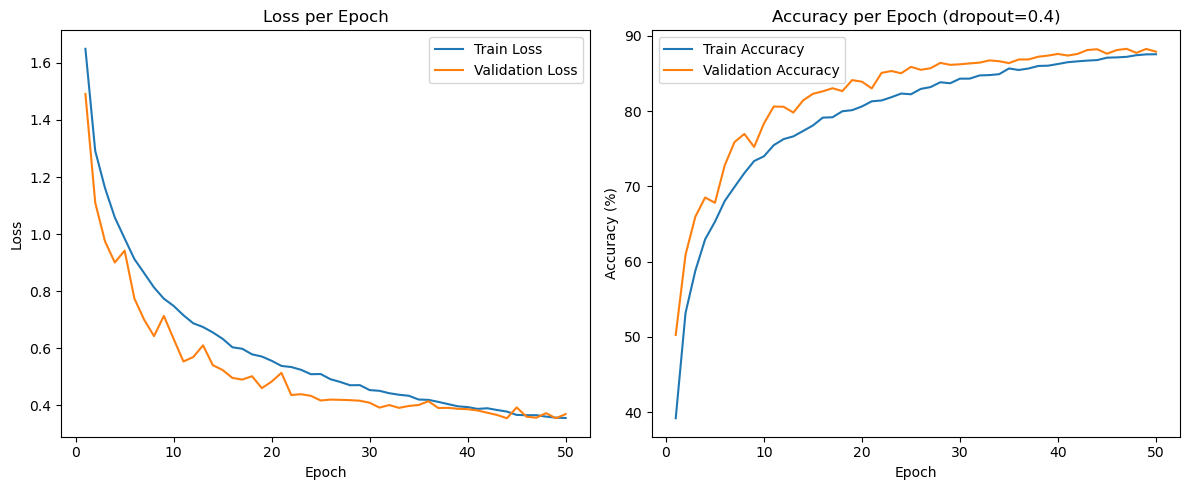

In [10]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (dropout=0.4)")
plt.legend()

plt.tight_layout()
plt.show()

# Dropout=0.45

In [11]:
drop_rate=0.45
resnet18_from_scratch = ResNet18(num_classes=10) 
model = resnet18_from_scratch.to(device) 
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification tasks
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training and validation functions
def train(model, loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to device (GPU/CPU)
        optimizer.zero_grad()  # Zero the gradients from the previous step
        outputs = model(inputs)  # Forward pass through the model
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters

        total_loss += loss.item()  # Accumulate the loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            outputs = model(inputs)  # Forward pass through the model
            loss = criterion(outputs, targets)  # Compute the loss

            total_loss += loss.item()  # Accumulate the loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50  # Set the number of epochs
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Train the model
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    # Validate the model
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    # Record the loss and accuracy for each epoch
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print the results for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "softmax_045.pth")


Epoch 1/50:
Train Loss: 1.6675, Train Acc: 38.31%
Val Loss: 1.3966, Val Acc: 50.98%
Epoch 2/50:
Train Loss: 1.3194, Train Acc: 52.40%
Val Loss: 1.1375, Val Acc: 59.60%
Epoch 3/50:
Train Loss: 1.1710, Train Acc: 58.12%
Val Loss: 0.9933, Val Acc: 65.44%
Epoch 4/50:
Train Loss: 1.0726, Train Acc: 62.23%
Val Loss: 0.8968, Val Acc: 69.11%
Epoch 5/50:
Train Loss: 1.0027, Train Acc: 64.50%
Val Loss: 0.9293, Val Acc: 67.88%
Epoch 6/50:
Train Loss: 0.9278, Train Acc: 67.65%
Val Loss: 0.7961, Val Acc: 72.07%
Epoch 7/50:
Train Loss: 0.8796, Train Acc: 69.53%
Val Loss: 0.6852, Val Acc: 76.02%
Epoch 8/50:
Train Loss: 0.8392, Train Acc: 70.86%
Val Loss: 0.7574, Val Acc: 74.13%
Epoch 9/50:
Train Loss: 0.7984, Train Acc: 72.33%
Val Loss: 0.6254, Val Acc: 78.35%
Epoch 10/50:
Train Loss: 0.7688, Train Acc: 73.58%
Val Loss: 0.6084, Val Acc: 78.72%
Epoch 11/50:
Train Loss: 0.7396, Train Acc: 74.55%
Val Loss: 0.5916, Val Acc: 79.36%
Epoch 12/50:
Train Loss: 0.7113, Train Acc: 75.45%
Val Loss: 0.5698, Val A

In [12]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.3880, Test Accuracy: 87.48%


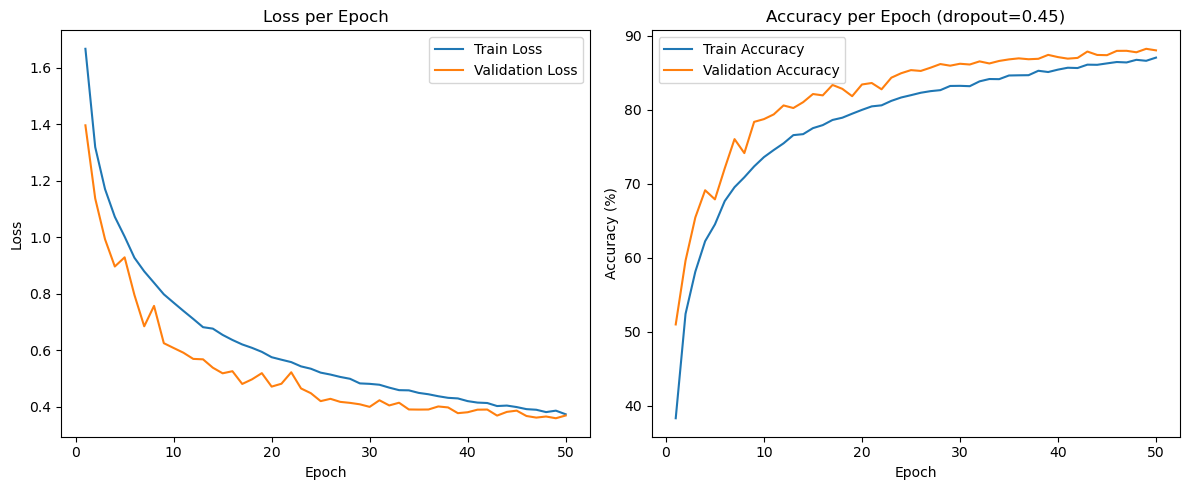

In [13]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (dropout=0.45)")
plt.legend()

plt.tight_layout()
plt.show()

# Dropout=0.5

In [14]:
drop_rate=0.5
resnet18_from_scratch = ResNet18(num_classes=10) 
model = resnet18_from_scratch.to(device) 
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification tasks
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training and validation functions
def train(model, loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to device (GPU/CPU)
        optimizer.zero_grad()  # Zero the gradients from the previous step
        outputs = model(inputs)  # Forward pass through the model
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters

        total_loss += loss.item()  # Accumulate the loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            outputs = model(inputs)  # Forward pass through the model
            loss = criterion(outputs, targets)  # Compute the loss

            total_loss += loss.item()  # Accumulate the loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50  # Set the number of epochs
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Train the model
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    # Validate the model
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    # Record the loss and accuracy for each epoch
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print the results for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "softmax_05.pth")


Epoch 1/50:
Train Loss: 1.6987, Train Acc: 37.16%
Val Loss: 1.3558, Val Acc: 50.44%
Epoch 2/50:
Train Loss: 1.3453, Train Acc: 51.14%
Val Loss: 1.1504, Val Acc: 59.42%
Epoch 3/50:
Train Loss: 1.2036, Train Acc: 57.06%
Val Loss: 1.0445, Val Acc: 63.45%
Epoch 4/50:
Train Loss: 1.1152, Train Acc: 60.38%
Val Loss: 1.0033, Val Acc: 65.05%
Epoch 5/50:
Train Loss: 1.0412, Train Acc: 63.08%
Val Loss: 0.9296, Val Acc: 67.82%
Epoch 6/50:
Train Loss: 0.9789, Train Acc: 65.72%
Val Loss: 0.8674, Val Acc: 69.98%
Epoch 7/50:
Train Loss: 0.9204, Train Acc: 67.94%
Val Loss: 0.7560, Val Acc: 73.89%
Epoch 8/50:
Train Loss: 0.8755, Train Acc: 69.78%
Val Loss: 0.7507, Val Acc: 74.48%
Epoch 9/50:
Train Loss: 0.8277, Train Acc: 71.38%
Val Loss: 0.6625, Val Acc: 77.09%
Epoch 10/50:
Train Loss: 0.8036, Train Acc: 72.16%
Val Loss: 0.6225, Val Acc: 78.21%
Epoch 11/50:
Train Loss: 0.7688, Train Acc: 73.36%
Val Loss: 0.6436, Val Acc: 77.43%
Epoch 12/50:
Train Loss: 0.7488, Train Acc: 74.10%
Val Loss: 0.6204, Val A

In [15]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.3853, Test Accuracy: 87.36%


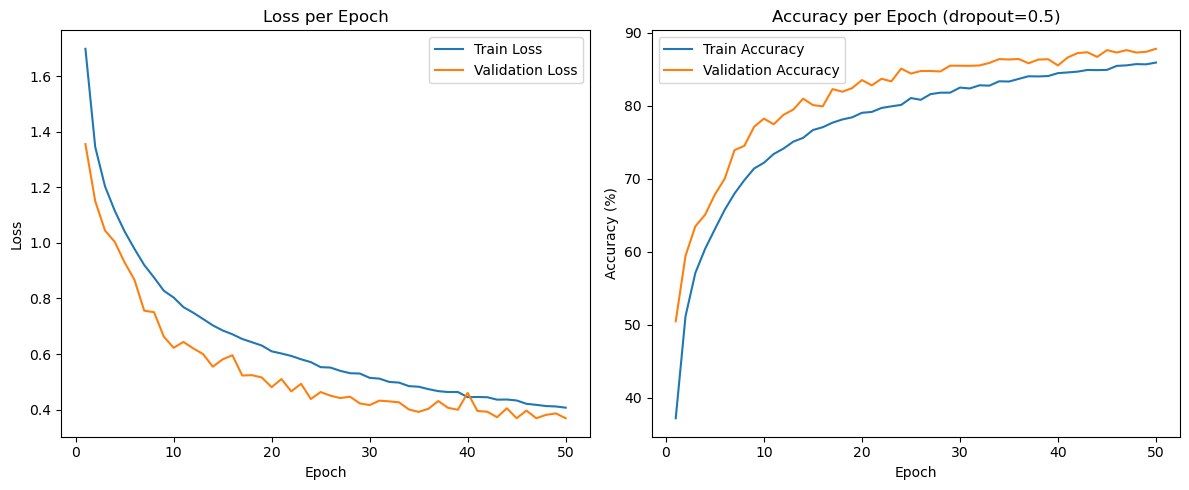

In [16]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (dropout=0.5)")
plt.legend()

plt.tight_layout()
plt.show()